# Least-squares technique

In [132]:
from functools import partial
import numpy as np
from scipy.stats import multivariate_normal, t
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, IntSlider

inv = np.linalg.inv

In [5]:
df = pd.read_csv('regression_data.csv')
df.head(3)

,x,y
0,0.047159,0.220033
1,0.064022,0.179399
2,0.080122,0.195405


## Population

0.5 and 0.2 are NOT the population parameters. Although we used them to generate the population, the population parameters can be different from them.

In [6]:
def get_y(x):
    ys =  x * 0.5 + 0.2
    noises = 1 * np.random.normal(size=len(ys))
    return ys + noises

In [7]:
np.random.seed(52)
xs = np.linspace(0, 10, 10000)
ys = get_y(xs)

np.random.seed(32)
np.random.shuffle(xs)
np.random.seed(32)
np.random.shuffle(ys)

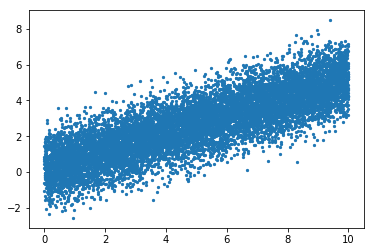

In [8]:
plt.scatter(xs, ys, s=5)
plt.show()

## Design matrices

In [9]:
PHI = xs.reshape(-1, 1)
PHI = np.hstack([
        PHI,
        np.ones(PHI.shape)
      ])
T = ys.reshape(-1, 1)

## Normal equation with regularization

In [10]:
def regularized_least_squares(PHI, T, regularizer=0):
    
    assert PHI.shape[0] == T.shape[0]
    
    pseudo_inv = inv(PHI.T @ PHI + np.eye(PHI.shape[1]) * regularizer)
    
    assert pseudo_inv.shape[0] == pseudo_inv.shape[1]
    
    W = pseudo_inv @ PHI.T @ T
    
    return {'slope' : float(W[0]), 'intercept' : float(W[1])}

## Sampling distributions

### Population parameters

In [11]:
pop_params = regularized_least_squares(PHI, T)

In [12]:
pop_slope, pop_intercept = pop_params['slope'], pop_params['intercept']

### Sample statistics

Verify that the sampling distribution for both regression coefficients are normal. 

In [78]:
n = 10  # sample size
num_samps = 1000

In [79]:
def sample(PHI, T, n):
    idxs = np.random.randint(PHI.shape[0], size=n)
    return PHI[idxs], T[idxs]

In [80]:
samp_slopes, samp_intercepts = [], []
for i in range(num_samps):
    PHI_samp, T_samp = sample(PHI, T, n)
    learned_param = regularized_least_squares(PHI_samp, T_samp)
    samp_slopes.append(learned_param['slope']); samp_intercepts.append(learned_param['intercept'])

In [81]:
np.std(samp_slopes), np.std(samp_intercepts)

(0.12050550210858654, 0.6887718661186888)

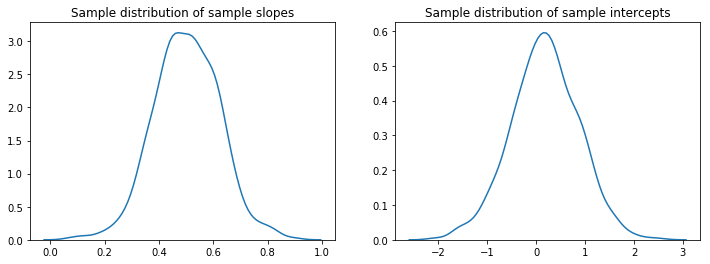

In [82]:
fig = plt.figure(figsize=(12, 4))

fig.add_subplot(121)
sns.kdeplot(samp_slopes)
plt.title('Sample distribution of sample slopes')

fig.add_subplot(122)
sns.kdeplot(samp_intercepts)
plt.title('Sample distribution of sample intercepts')

plt.show()

Note that the two normal distributions above are correlated. This means that we need to be careful when plotting the 95% CI for the regression line, because we can't just plot the regression line with the highest slope and the highest intercept and the regression line with the lowest slope and the lowest intercept.

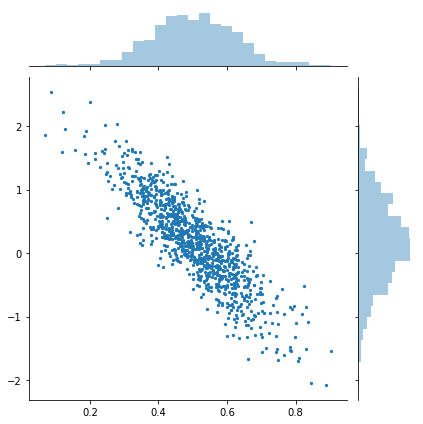

In [83]:
sns.jointplot(samp_slopes, samp_intercepts, s=5)
plt.show()

## Confidence interval

**Caution.** The following computation of confidence intervals does not apply to regularized least squares.

### Sample one sample

In [247]:
n = 500
PHI_samp, T_samp = sample(PHI, T, n)

### Compute sample statistics

In [248]:
learned_param = regularized_least_squares(PHI_samp, T_samp)

In [249]:
samp_slope, samp_intercept = learned_param['slope'], learned_param['intercept']

In [250]:
samp_slope, samp_intercept

(0.5199886683728594, 0.13349132119993573)

### Compute standard errors of sample statistics

Standard error is the estimate of the standard deviation of the sampling distribution.

$$\hat\sigma = \sqrt{\frac{\text{Sum of all squared residuals}}{\text{Degrees of freedom}}}$$

Standard error for slope:
$$\text{SE}(\hat\beta_1)=\hat\sigma \sqrt{\frac{1}{(n-1)s_X^2}}$$

Standard error for intercept:

$$\text{SE}(\hat\beta_0)=\hat\sigma \sqrt{\frac{1}{n} + \frac{\bar X^2}{(n-1)s_X^2}}$$

where $\bar X$ is the sample mean of the $X$'s and $s_X^2$ is the sample variance of the $X$'s.

In [251]:
preds = samp_slope * PHI_samp[:,0] + samp_intercept
sum_of_squared_residuals = np.sum((T_samp.reshape(-1) - preds) ** 2)
samp_sigma_y_give_x = np.sqrt(sum_of_squared_residuals / (n - 2))

In [252]:
samp_sigma_y_give_x

0.9649713702032595

In [253]:
samp_mean = np.mean(PHI_samp[:,0])
samp_var = np.var(PHI_samp[:,0])

In [254]:
SE_slope = samp_sigma_y_give_x * np.sqrt(1 / ((n - 1) * samp_var))
SE_intercept = samp_sigma_y_give_x * np.sqrt(1 / n + samp_mean ** 2 / ((n - 1) * samp_var))

In [255]:
SE_slope, SE_intercept

(0.015279859867060605, 0.0886253642689882)

### Compute confidence intervals for sample statistics

In [256]:
slope_lower, slope_upper = samp_slope - 1.96 * SE_slope, samp_slope + 1.96 * SE_slope
slope_lower, slope_upper

(0.4900401430334206, 0.5499371937122982)

In [257]:
intercept_lower, intercept_upper = samp_intercept - 1.96 * SE_intercept, samp_intercept + 1.96 * SE_intercept
intercept_lower, intercept_upper

(-0.04021439276728114, 0.3071970351671526)

### Compute confidence interval for regression line

#### Boostrapped solution

Use a 2-d Guassian to model the joint distribution between boostrapped sample slopes and boostrapped sample intercepts.

**Fixed.** `samp_slopes` and `samp_intercepts` used in the cell below are not boostrapped; they are directly sampled from the population. Next time, add the boostrapped version. Using `samp_slopes` and `samp_intercepts` still has its value, though; it shows the population regression line lie right in the middle of all sample regression lines. Remember that, when ever you use bootstrapping to estimate the variance / covariance of the sample distribution of some statistic, there might be an equation that you can use from statistical theory. 

In [258]:
num_resamples = 10000

In [259]:
resample_slopes, resample_intercepts = [], []
for i in range(num_resamples):
    PHI_resample, T_resample = sample(PHI_samp, T_samp, n=len(PHI_samp))
    learned_params = regularized_least_squares(PHI_resample, T_resample)
    resample_slopes.append(learned_params['slope']); resample_intercepts.append(learned_params['intercept'])

**Fixed.** The following steps might improve the results, but I don't think they are part of the standard practice.

In [269]:
# means = [np.mean(resample_slopes), np.mean(resample_intercepts)]
# cov = np.cov(resample_slopes, resample_intercepts)

In [270]:
# model = multivariate_normal(mean=means, cov=cov)

Sample 5000 (slope, intercept) pairs from the Gaussian.

In [271]:
# num_pairs_sampled = 10000
# pairs = model.rvs(num_pairs_sampled)

Scatter samples, plot regression lines and CI.

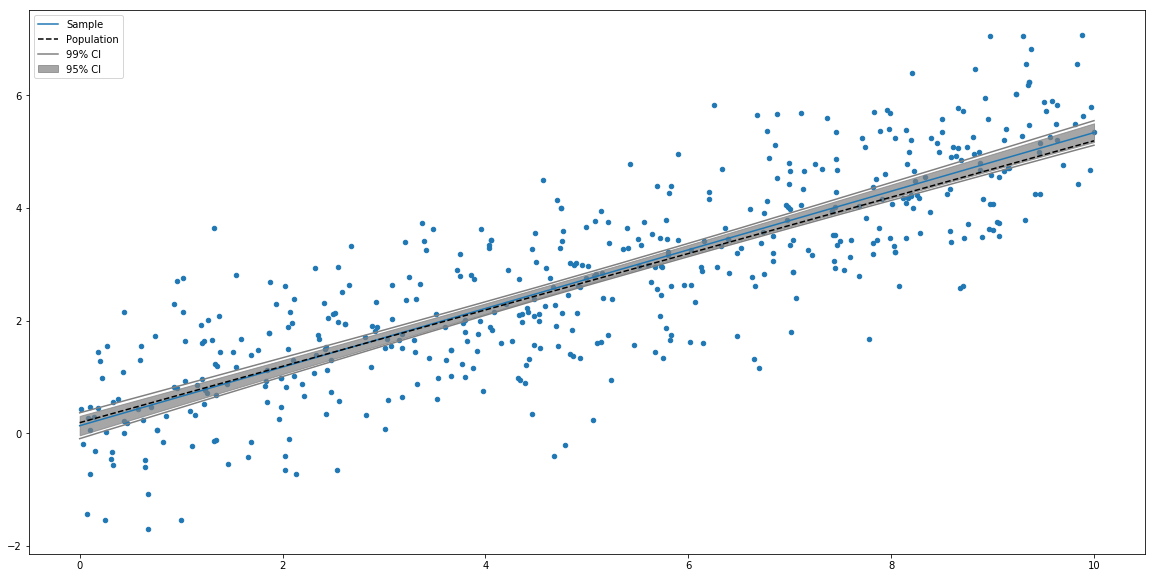

In [272]:
plt.figure(figsize=(20, 10))

plt.scatter(PHI_samp[:,0], T_samp.reshape(-1), s=20)  # sample

granularity = 1000
xs = np.linspace(0, 10, granularity)

plt.plot(xs, samp_slope  * xs + samp_intercept, label='Sample')  # sample regression line
plt.plot(xs, pop_slope   * xs + pop_intercept, '--', color='black', label='Population')  # population regression line

lines = np.zeros((num_resamples, granularity))
for i, (slope, intercept) in enumerate(zip(resample_slopes, resample_intercepts)):
    lines[i] = slope * xs + intercept
    
confidence_level = 95
    
uppers_95 = np.percentile(lines, confidence_level + (100 - confidence_level) / 2, axis=0)
lowers_95 = np.percentile(lines, (100 - confidence_level) / 2, axis=0)

confidence_level = 99

uppers_99 = np.percentile(lines, confidence_level + (100 - confidence_level) / 2, axis=0)
lowers_99 = np.percentile(lines, (100 - confidence_level) / 2, axis=0)

plt.fill_between(xs, lowers_95, uppers_95, color='grey', alpha=0.7, label='95% CI')
plt.plot(xs, uppers_99, color='grey', label='99% CI')
plt.plot(xs, lowers_99, color='grey')

plt.legend()
plt.show()

#### Analytic solution

**Reference.** Page 97, Statistics of Geograph: A Practical Approach, David Ebdon, 1987.

For a particular value $x_0$ of the independent variable $x$, its confidence interval is given by:


$$\sqrt{\frac{\sum e^{2}}{n-2}\left[\frac{1}{n}+\frac{\left(x_{0}-\bar{x}\right)^{2}}{\sum x^{2}-n \bar{x}^{2}}\right]}$$

where
- $\sum e^2$ is the sum of squares of residuals from regression,
- $x$ is the independent variables,
- $\bar{x}$ is the sample mean of the independent variables.

In [264]:
sum_of_squared_xs = np.sum(PHI_samp[:,0] ** 2)

In [265]:
SEs = np.sqrt(
    (sum_of_squared_residuals / (n - 2)) *
    (1 / n + (xs - samp_mean) ** 2 / (sum_of_squared_xs - n * samp_mean ** 2))
)

In [266]:
t_97dot5 = t.ppf(0.975, df=n-2)
t_99dot5 = t.ppf(0.995, df=n-2)

In [267]:
yhats = samp_slope * xs + samp_intercept

uppers_95 = yhats + t_97dot5 * SEs
lowers_95 = yhats - t_97dot5 * SEs

uppers_99 = yhats + t_99dot5 * SEs
lowers_99 = yhats - t_99dot5 * SEs

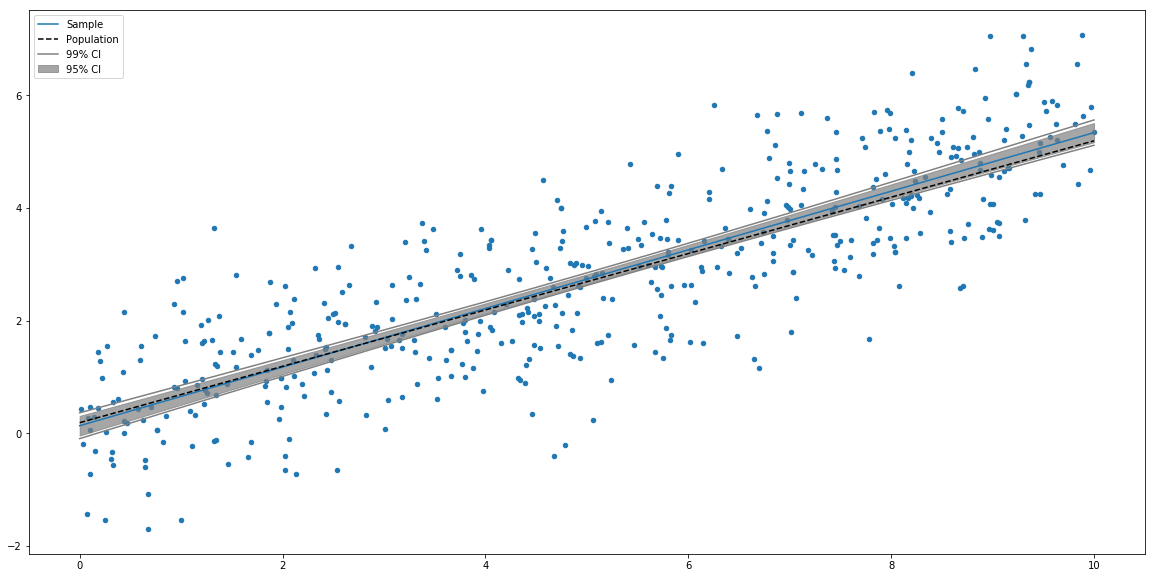

In [268]:
plt.figure(figsize=(20, 10))

plt.scatter(PHI_samp[:,0], T_samp.reshape(-1), s=20)  # sample

granularity = 1000
xs = np.linspace(0, 10, granularity)

plt.plot(xs, samp_slope  * xs + samp_intercept, label='Sample')  # sample regression line
plt.plot(xs, pop_slope   * xs + pop_intercept, '--', color='black', label='Population')  # population regression line

plt.fill_between(xs, lowers_95, uppers_95, color='grey', alpha=0.7, label='95% CI')

plt.plot(xs, uppers_99, color='grey', label='99% CI')
plt.plot(xs, lowers_99, color='grey')

plt.legend()
plt.show()


## Regularized least squares

In [36]:
def plot_regression_line(PHI, T, regularizer):
    
    plt.scatter(PHI[:,0], T, s=5)
    
    params = regularized_least_squares(PHI, T, regularizer)
    
    x_min, x_max = PHI[:,0].min(), PHI[:,0].max()
    xs = np.linspace(x_min, x_max, 2)
    ys = params['slope'] * xs + params['intercept']
    
    plt.plot(xs, ys, color='orange')
    
    plt.ylim(-3, 10)
    
    plt.show()

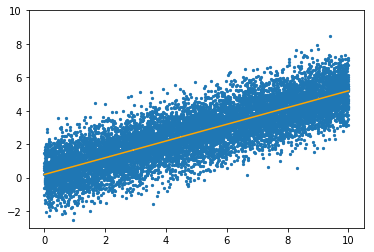

In [37]:
plot_regression_line(PHI, T, regularizer=20)

In [38]:
def plot_regression_line_wrapper(regularizer, num_points):
    plot_regression_line(PHI[:num_points], T[:num_points], regularizer)

Yes! The effect of regularization does change with the size of the dataset.

In [39]:
_ = interact(
    plot_regression_line_wrapper, 
    regularizer=IntSlider(min=0, max=10000, value=5000, continuous_update=False),
    num_points=IntSlider(min=2, max=1000, value=1000, continuous_update=False)
)

interactive(children=(IntSlider(value=5000, continuous_update=False, description='regularizer', max=10000), In…